In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!nvidia-smi

Sun Oct 15 09:07:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    29W /  70W |    361MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
train_dir = "/content/gdrive/MyDrive/DL_Project/fl_dt"

output_hr_dir = os.path.join(train_dir, "hr_images_1")
output_lr_dir = os.path.join(train_dir, "lr_images_1")
os.makedirs(output_hr_dir, exist_ok=True)
os.makedirs(output_lr_dir, exist_ok=True)

for img_filename in os.listdir(train_dir):
    img_path = os.path.join(train_dir, img_filename)
    img_array = cv2.imread(img_path)

    if img_array is not None and img_array.shape[0] > 0 and img_array.shape[1] > 0:
        print(f"Processing: {img_filename} - Original Shape: {img_array.shape}")
        img_array_hr = cv2.resize(img_array, (128, 128))
        img_array_lr = cv2.resize(img_array, (32, 32))
        cv2.imwrite(os.path.join(output_hr_dir, img_filename), img_array_hr)
        cv2.imwrite(os.path.join(output_lr_dir, img_filename), img_array_lr)
        print(f"Processed: {img_filename} - HR Shape: {img_array_hr.shape}, LR Shape: {img_array_lr.shape}")
    else:
        print(f"Error processing image: {img_filename}")


Processing: dandelion_0_-2e8f454bd101c6cc.jpg - Original Shape: (213, 320, 3)
Processed: dandelion_0_-2e8f454bd101c6cc.jpg - HR Shape: (128, 128, 3), LR Shape: (32, 32, 3)
Processing: roses_4_660d3ce4d1ad5a9e.jpg - Original Shape: (240, 320, 3)
Processed: roses_4_660d3ce4d1ad5a9e.jpg - HR Shape: (128, 128, 3), LR Shape: (32, 32, 3)
Processing: tulips_2_1a7a6f494e5ff1a3.jpg - Original Shape: (213, 320, 3)
Processed: tulips_2_1a7a6f494e5ff1a3.jpg - HR Shape: (128, 128, 3), LR Shape: (32, 32, 3)
Processing: sunflowers_3_-73170f1a7c9a9297.jpg - Original Shape: (240, 180, 3)
Processed: sunflowers_3_-73170f1a7c9a9297.jpg - HR Shape: (128, 128, 3), LR Shape: (32, 32, 3)
Processing: roses_4_-65776824dd69af62.jpg - Original Shape: (240, 240, 3)
Processed: roses_4_-65776824dd69af62.jpg - HR Shape: (128, 128, 3), LR Shape: (32, 32, 3)
Processing: roses_4_56a99201d39c1336.jpg - Original Shape: (333, 500, 3)
Processed: roses_4_56a99201d39c1336.jpg - HR Shape: (128, 128, 3), LR Shape: (32, 32, 3)
Pr

In [ ]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [ ]:
#Define blocks to build the generator
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


In [ ]:
from keras.applications import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [ ]:
lr_list = os.listdir("/content/gdrive/MyDrive/DL_Project/fl_dt/lr_images_1")

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/gdrive/MyDrive/DL_Project/fl_dt/lr_images_1/" + img)
    if img_lr is not None:
        img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
        lr_images.append(img_lr)

hr_list = os.listdir("/content/gdrive/MyDrive/DL_Project/fl_dt/hr_images_1")

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/gdrive/MyDrive/DL_Project/fl_dt/hr_images_1/" + img)
    if img_hr is not None:
        img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
        hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)



In [ ]:
lr_images = lr_images / 255.
hr_images = hr_images / 255.

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,
                                                      test_size=0.33, random_state=42)


hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 32, 32, 64)           64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['p_re_lu[0][0]']             
                                                                                              

In [ ]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])


epochs = 5
for e in range(epochs):

    fake_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size,1))

    g_losses = []
    d_losses = []


    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]

        fake_imgs = generator.predict_on_batch(lr_imgs)


        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)


        discriminator.trainable = False


        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)


        image_features = vgg.predict(hr_imgs)



        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])


        d_losses.append(d_loss)
        g_losses.append(g_loss)

    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    generator.save("/content/gdrive/MyDrive/DL_Project/gen_e.h5")

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 128, 128, 3)          2044291   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    3824928   ['model[0][0]']               
                                                          1                                 

  0%|          | 0/402 [00:00<?, ?it/s]

1/1 [==============================] - 1s 527ms/step


  0%|          | 1/402 [00:46<5:13:52, 46.96s/it]

1/1 [==============================] - 0s 17ms/step


  0%|          | 2/402 [00:47<2:09:39, 19.45s/it]

1/1 [==============================] - 0s 18ms/step


  1%|          | 3/402 [00:47<1:10:50, 10.65s/it]

1/1 [==============================] - 0s 26ms/step


  1%|          | 4/402 [00:47<43:14,  6.52s/it]  

1/1 [==============================] - 0s 17ms/step


  1%|          | 5/402 [00:47<27:58,  4.23s/it]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 6/402 [00:47<18:47,  2.85s/it]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 7/402 [00:48<12:57,  1.97s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 8/402 [00:48<09:09,  1.40s/it]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 9/402 [00:48<06:36,  1.01s/it]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 10/402 [00:48<04:53,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 11/402 [00:48<03:41,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 12/402 [00:48<02:51,  2.27it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 13/402 [00:48<02:17,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 14/402 [00:49<01:55,  3.37it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 15/402 [00:49<01:37,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 16/402 [00:49<01:26,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 17/402 [00:49<01:19,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 18/402 [00:49<01:13,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 19/402 [00:49<01:08,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 20/402 [00:50<01:06,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 21/402 [00:50<01:04,  5.95it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 22/402 [00:50<01:05,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 23/402 [00:50<01:04,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 24/402 [00:50<01:01,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 25/402 [00:50<01:00,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 26/402 [00:51<01:03,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 27/402 [00:51<01:04,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 28/402 [00:51<01:01,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 29/402 [00:51<01:00,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 30/402 [00:51<00:59,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 31/402 [00:51<00:59,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 32/402 [00:52<01:00,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 33/402 [00:52<01:00,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 34/402 [00:52<00:59,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 35/402 [00:52<00:58,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 36/402 [00:52<00:59,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 37/402 [00:52<00:59,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 38/402 [00:53<00:59,  6.13it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 39/402 [00:53<01:04,  5.61it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 40/402 [00:53<01:08,  5.25it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 41/402 [00:53<01:17,  4.64it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 42/402 [00:53<01:17,  4.66it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 43/402 [00:54<01:17,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 44/402 [00:54<01:18,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 45/402 [00:54<01:17,  4.60it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█▏        | 46/402 [00:54<01:20,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 47/402 [00:55<01:21,  4.38it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 48/402 [00:55<01:18,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 49/402 [00:55<01:19,  4.45it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 50/402 [00:55<01:20,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 51/402 [00:55<01:17,  4.52it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 52/402 [00:56<01:22,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 53/402 [00:56<01:23,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 54/402 [00:56<01:16,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 55/402 [00:56<01:11,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 56/402 [00:56<01:07,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 57/402 [00:57<01:03,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 58/402 [00:57<01:02,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 59/402 [00:57<01:00,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 60/402 [00:57<00:58,  5.84it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 61/402 [00:57<00:57,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 62/402 [00:57<00:56,  5.99it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 63/402 [00:58<00:54,  6.17it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 64/402 [00:58<00:55,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 65/402 [00:58<00:54,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 66/402 [00:58<00:55,  6.06it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 67/402 [00:58<00:56,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 68/402 [00:59<01:00,  5.51it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 69/402 [00:59<00:58,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 70/402 [00:59<00:56,  5.91it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 71/402 [00:59<00:54,  6.05it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 72/402 [00:59<00:54,  6.06it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 73/402 [00:59<00:55,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 74/402 [00:59<00:54,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 75/402 [01:00<00:53,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 76/402 [01:00<00:52,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 77/402 [01:00<00:51,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 78/402 [01:00<00:51,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 79/402 [01:00<00:50,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 80/402 [01:00<00:50,  6.44it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 81/402 [01:01<00:52,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 82/402 [01:01<00:51,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 83/402 [01:01<00:50,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 84/402 [01:01<00:49,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 85/402 [01:01<00:50,  6.29it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 86/402 [01:01<00:50,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 87/402 [01:02<00:53,  5.85it/s]

1/1 [==============================] - 0s 137ms/step


 22%|██▏       | 88/402 [01:02<01:29,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 89/402 [01:02<01:28,  3.55it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 90/402 [01:03<01:16,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 91/402 [01:03<01:07,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 92/402 [01:03<01:01,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 93/402 [01:03<00:58,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 94/402 [01:03<00:54,  5.65it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 95/402 [01:03<00:51,  5.91it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 96/402 [01:03<00:51,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 97/402 [01:04<00:49,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 98/402 [01:04<00:49,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 99/402 [01:04<00:50,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 100/402 [01:04<00:51,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 101/402 [01:04<00:52,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 102/402 [01:05<00:54,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 103/402 [01:05<00:53,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 104/402 [01:05<00:51,  5.78it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 105/402 [01:05<00:50,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 106/402 [01:05<00:49,  6.03it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 107/402 [01:05<00:47,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 108/402 [01:06<00:48,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 109/402 [01:06<00:47,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 110/402 [01:06<00:47,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 111/402 [01:06<00:49,  5.91it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 112/402 [01:06<00:53,  5.45it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 113/402 [01:06<00:57,  4.99it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 114/402 [01:07<00:59,  4.80it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 115/402 [01:07<01:00,  4.72it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 116/402 [01:07<01:02,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 117/402 [01:07<01:01,  4.62it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 118/402 [01:08<01:03,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 119/402 [01:08<01:02,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 120/402 [01:08<01:02,  4.54it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 121/402 [01:08<01:05,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 122/402 [01:09<01:04,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 123/402 [01:09<01:04,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 124/402 [01:09<01:03,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 125/402 [01:09<01:03,  4.38it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 126/402 [01:09<01:04,  4.25it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 127/402 [01:10<01:00,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 128/402 [01:10<00:56,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 129/402 [01:10<00:53,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 130/402 [01:10<00:51,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 131/402 [01:10<00:48,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 132/402 [01:11<00:49,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 133/402 [01:11<00:50,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 134/402 [01:11<00:48,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 135/402 [01:11<00:46,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 136/402 [01:11<00:46,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 137/402 [01:11<00:48,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 138/402 [01:12<00:46,  5.64it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 139/402 [01:12<00:45,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 140/402 [01:12<00:45,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 141/402 [01:12<00:44,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 142/402 [01:12<00:43,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 143/402 [01:12<00:44,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 144/402 [01:13<00:43,  5.90it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 145/402 [01:13<00:43,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 146/402 [01:13<00:43,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 147/402 [01:13<00:41,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 148/402 [01:13<00:41,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 149/402 [01:13<00:41,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 150/402 [01:14<00:40,  6.16it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 151/402 [01:14<00:42,  5.90it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 152/402 [01:14<00:41,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 153/402 [01:14<00:43,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 154/402 [01:14<00:42,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 155/402 [01:14<00:41,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 156/402 [01:15<00:40,  6.03it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 157/402 [01:15<00:40,  6.02it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 158/402 [01:15<00:40,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 159/402 [01:15<00:39,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 160/402 [01:15<00:39,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 161/402 [01:15<00:39,  6.17it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 162/402 [01:16<00:39,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 163/402 [01:16<00:39,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 164/402 [01:16<00:38,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 165/402 [01:16<00:38,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 166/402 [01:16<00:38,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 167/402 [01:16<00:38,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 168/402 [01:17<00:38,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 169/402 [01:17<00:37,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 170/402 [01:17<00:38,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 171/402 [01:17<00:37,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 172/402 [01:17<00:37,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 173/402 [01:17<00:36,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 174/402 [01:18<00:36,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 175/402 [01:18<00:36,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 176/402 [01:18<00:35,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 177/402 [01:18<00:37,  5.95it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 178/402 [01:18<00:39,  5.66it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 179/402 [01:18<00:38,  5.83it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 180/402 [01:19<00:37,  5.93it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 181/402 [01:19<00:36,  6.02it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 182/402 [01:19<00:36,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 183/402 [01:19<00:35,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 184/402 [01:19<00:35,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 185/402 [01:19<00:35,  6.11it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 186/402 [01:20<00:37,  5.82it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 187/402 [01:20<00:40,  5.33it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 188/402 [01:20<00:41,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 189/402 [01:20<00:42,  5.04it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 190/402 [01:20<00:42,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 191/402 [01:21<00:44,  4.72it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 192/402 [01:21<00:46,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 193/402 [01:21<00:47,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 194/402 [01:21<00:45,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 195/402 [01:22<00:45,  4.58it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 196/402 [01:22<00:44,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 197/402 [01:22<00:44,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 198/402 [01:22<00:45,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 199/402 [01:22<00:44,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 200/402 [01:23<00:45,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 201/402 [01:23<00:45,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 202/402 [01:23<00:43,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 203/402 [01:23<00:39,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 204/402 [01:23<00:37,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 205/402 [01:24<00:36,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 206/402 [01:24<00:35,  5.52it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 207/402 [01:24<00:36,  5.34it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 208/402 [01:24<00:35,  5.50it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 209/402 [01:24<00:34,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 210/402 [01:24<00:33,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 211/402 [01:25<00:34,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 212/402 [01:25<00:33,  5.67it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 213/402 [01:25<00:32,  5.83it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 214/402 [01:25<00:32,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 215/402 [01:25<00:33,  5.58it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 216/402 [01:25<00:32,  5.78it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 217/402 [01:26<00:33,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 218/402 [01:26<00:31,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 219/402 [01:26<00:31,  5.80it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 220/402 [01:26<00:31,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 221/402 [01:26<00:30,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 222/402 [01:27<00:30,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 223/402 [01:27<00:29,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 224/402 [01:27<00:29,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 225/402 [01:27<00:29,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 226/402 [01:27<00:29,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 227/402 [01:27<00:30,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 228/402 [01:28<00:29,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 229/402 [01:28<00:28,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 230/402 [01:28<00:28,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 231/402 [01:28<00:27,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 232/402 [01:28<00:28,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 233/402 [01:28<00:28,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 234/402 [01:29<00:28,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 235/402 [01:29<00:27,  6.02it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 236/402 [01:29<00:27,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 237/402 [01:29<00:27,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 238/402 [01:29<00:26,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 239/402 [01:29<00:27,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 240/402 [01:30<00:27,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 241/402 [01:30<00:27,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 242/402 [01:30<00:27,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 243/402 [01:30<00:27,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 244/402 [01:30<00:26,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 245/402 [01:30<00:26,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 246/402 [01:31<00:26,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 247/402 [01:31<00:25,  6.06it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 248/402 [01:31<00:25,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 249/402 [01:31<00:25,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 250/402 [01:31<00:25,  5.99it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 251/402 [01:31<00:24,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 252/402 [01:32<00:24,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 253/402 [01:32<00:25,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 254/402 [01:32<00:24,  5.97it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 255/402 [01:32<00:24,  5.93it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 256/402 [01:32<00:24,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 257/402 [01:32<00:25,  5.69it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 258/402 [01:33<00:24,  5.77it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 259/402 [01:33<00:24,  5.89it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 260/402 [01:33<00:23,  6.02it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 261/402 [01:33<00:25,  5.53it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 262/402 [01:33<00:26,  5.19it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 263/402 [01:34<00:27,  5.00it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 264/402 [01:34<00:28,  4.92it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 265/402 [01:34<00:28,  4.82it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 266/402 [01:34<00:29,  4.68it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 267/402 [01:34<00:30,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 268/402 [01:35<00:30,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 269/402 [01:35<00:30,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 270/402 [01:35<00:29,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 271/402 [01:35<00:29,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 272/402 [01:36<00:29,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 273/402 [01:36<00:29,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 274/402 [01:36<00:29,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 275/402 [01:36<00:29,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 276/402 [01:36<00:28,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 277/402 [01:37<00:26,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 278/402 [01:37<00:24,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 279/402 [01:37<00:24,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 280/402 [01:37<00:23,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 281/402 [01:37<00:23,  5.25it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 282/402 [01:38<00:23,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 283/402 [01:38<00:21,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 284/402 [01:38<00:22,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 285/402 [01:38<00:21,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 286/402 [01:38<00:20,  5.55it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 287/402 [01:38<00:20,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 288/402 [01:39<00:20,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 289/402 [01:39<00:20,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 290/402 [01:39<00:19,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 291/402 [01:39<00:18,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 292/402 [01:39<00:18,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 293/402 [01:40<00:18,  5.89it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 294/402 [01:40<00:18,  5.97it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 295/402 [01:40<00:17,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 296/402 [01:40<00:17,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 297/402 [01:40<00:17,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 298/402 [01:40<00:17,  5.99it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 299/402 [01:41<00:17,  5.88it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 300/402 [01:41<00:17,  5.97it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 301/402 [01:41<00:16,  6.06it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 302/402 [01:41<00:16,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 303/402 [01:41<00:16,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 304/402 [01:41<00:16,  6.12it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 305/402 [01:41<00:16,  5.95it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 306/402 [01:42<00:15,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 307/402 [01:42<00:15,  6.04it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 308/402 [01:42<00:15,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 309/402 [01:42<00:15,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 310/402 [01:42<00:15,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 311/402 [01:42<00:15,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 312/402 [01:43<00:14,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 313/402 [01:43<00:14,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 314/402 [01:43<00:14,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 315/402 [01:43<00:14,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 316/402 [01:43<00:14,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 317/402 [01:43<00:13,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 318/402 [01:44<00:13,  6.12it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 319/402 [01:44<00:13,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 320/402 [01:44<00:14,  5.75it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 321/402 [01:44<00:13,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 322/402 [01:44<00:13,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 323/402 [01:44<00:13,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 324/402 [01:45<00:12,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 325/402 [01:45<00:12,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 326/402 [01:45<00:12,  6.09it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 327/402 [01:45<00:12,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 328/402 [01:45<00:11,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 329/402 [01:45<00:11,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 330/402 [01:46<00:11,  6.01it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 331/402 [01:46<00:12,  5.85it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 332/402 [01:46<00:11,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 333/402 [01:46<00:11,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 334/402 [01:46<00:11,  6.11it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 335/402 [01:47<00:13,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 336/402 [01:47<00:13,  4.89it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 337/402 [01:47<00:13,  4.82it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 338/402 [01:47<00:13,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 339/402 [01:47<00:13,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 340/402 [01:48<00:13,  4.70it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 341/402 [01:48<00:13,  4.66it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 342/402 [01:48<00:13,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 343/402 [01:48<00:13,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 344/402 [01:49<00:13,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 345/402 [01:49<00:13,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 346/402 [01:49<00:13,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 347/402 [01:49<00:12,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 348/402 [01:50<00:12,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 349/402 [01:50<00:12,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 350/402 [01:50<00:11,  4.45it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 351/402 [01:50<00:10,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 352/402 [01:50<00:10,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 353/402 [01:51<00:09,  5.15it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 354/402 [01:51<00:09,  5.24it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 355/402 [01:51<00:08,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 356/402 [01:51<00:08,  5.46it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 357/402 [01:51<00:08,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 358/402 [01:51<00:07,  5.75it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 359/402 [01:52<00:07,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 360/402 [01:52<00:07,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 361/402 [01:52<00:07,  5.33it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 362/402 [01:52<00:07,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 363/402 [01:52<00:07,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 364/402 [01:52<00:06,  5.72it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 365/402 [01:53<00:06,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 366/402 [01:53<00:06,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 367/402 [01:53<00:05,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 368/402 [01:53<00:05,  5.90it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 369/402 [01:53<00:05,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 370/402 [01:53<00:05,  5.96it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 371/402 [01:54<00:05,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 372/402 [01:54<00:04,  6.01it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 373/402 [01:54<00:04,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 374/402 [01:54<00:04,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 375/402 [01:54<00:04,  6.22it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 376/402 [01:54<00:04,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 377/402 [01:55<00:04,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 378/402 [01:55<00:04,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 379/402 [01:55<00:03,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 380/402 [01:55<00:03,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 381/402 [01:55<00:03,  5.68it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 382/402 [01:55<00:03,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 383/402 [01:56<00:03,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 384/402 [01:56<00:03,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 385/402 [01:56<00:03,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 386/402 [01:56<00:02,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 387/402 [01:56<00:02,  5.69it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 388/402 [01:57<00:02,  5.56it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 389/402 [01:57<00:02,  5.70it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 390/402 [01:57<00:02,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 391/402 [01:57<00:02,  5.35it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 392/402 [01:57<00:01,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 393/402 [01:57<00:01,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 394/402 [01:58<00:01,  5.50it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 395/402 [01:58<00:01,  5.65it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 396/402 [01:58<00:01,  5.78it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 397/402 [01:58<00:00,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 398/402 [01:58<00:00,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 399/402 [01:59<00:00,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 400/402 [01:59<00:00,  5.75it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 401/402 [01:59<00:00,  5.62it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 402/402 [01:59<00:00,  3.36it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


epoch: 1 g_loss: 103.79400591589325 d_loss: [3.03557296 0.83333333]


  0%|          | 0/402 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 1/402 [00:00<01:44,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 2/402 [00:00<01:40,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 3/402 [00:00<01:39,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 4/402 [00:01<01:43,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 5/402 [00:01<01:39,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 6/402 [00:01<01:40,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 7/402 [00:01<01:38,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 8/402 [00:01<01:34,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 9/402 [00:02<01:33,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 10/402 [00:02<01:36,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 11/402 [00:02<01:28,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 12/402 [00:02<01:23,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 13/402 [00:03<01:19,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 14/402 [00:03<01:18,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 15/402 [00:03<01:19,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 16/402 [00:03<01:22,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 17/402 [00:03<01:17,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 18/402 [00:04<01:14,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 19/402 [00:04<01:12,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 20/402 [00:04<01:14,  5.11it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 21/402 [00:04<01:11,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 22/402 [00:04<01:09,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 23/402 [00:04<01:07,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 24/402 [00:05<01:07,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 25/402 [00:05<01:06,  5.65it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 26/402 [00:05<01:06,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 27/402 [00:05<01:05,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 28/402 [00:05<01:06,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 29/402 [00:05<01:05,  5.71it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 30/402 [00:06<01:04,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 31/402 [00:06<01:04,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 32/402 [00:06<01:06,  5.57it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 33/402 [00:06<01:04,  5.69it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 34/402 [00:06<01:03,  5.78it/s]

1/1 [==============================] - 0s 115ms/step


  9%|▊         | 35/402 [00:07<01:40,  3.66it/s]

1/1 [==============================] - 0s 107ms/step


  9%|▉         | 36/402 [00:07<02:12,  2.77it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 37/402 [00:08<01:52,  3.25it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 38/402 [00:08<01:36,  3.76it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 39/402 [00:08<01:30,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 40/402 [00:08<01:23,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 41/402 [00:08<01:16,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 42/402 [00:09<01:11,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 43/402 [00:09<01:10,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 44/402 [00:09<01:08,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 45/402 [00:09<01:05,  5.42it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 46/402 [00:09<01:06,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 47/402 [00:09<01:06,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 48/402 [00:10<01:04,  5.50it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 49/402 [00:10<01:02,  5.65it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 50/402 [00:10<01:01,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 51/402 [00:10<00:59,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 52/402 [00:10<00:59,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 53/402 [00:10<00:59,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 54/402 [00:11<00:58,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 55/402 [00:11<00:57,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 56/402 [00:11<00:58,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 57/402 [00:11<00:59,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 58/402 [00:11<00:58,  5.90it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 59/402 [00:11<01:00,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 60/402 [00:12<01:00,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 61/402 [00:12<00:59,  5.69it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 62/402 [00:12<01:02,  5.46it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 63/402 [00:12<01:07,  5.03it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 64/402 [00:12<01:11,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 65/402 [00:13<01:13,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 66/402 [00:13<01:14,  4.52it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 67/402 [00:13<01:15,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 68/402 [00:13<01:17,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 69/402 [00:14<01:15,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 70/402 [00:14<01:16,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 71/402 [00:14<01:18,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 72/402 [00:14<01:17,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 73/402 [00:15<01:18,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 74/402 [00:15<01:19,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 75/402 [00:15<01:19,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 76/402 [00:15<01:18,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 77/402 [00:16<01:17,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 78/402 [00:16<01:13,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 79/402 [00:16<01:11,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 80/402 [00:16<01:07,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 81/402 [00:16<01:04,  4.98it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 82/402 [00:17<01:01,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 83/402 [00:17<01:00,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 84/402 [00:17<00:58,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 85/402 [00:17<00:57,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 86/402 [00:17<00:57,  5.53it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 87/402 [00:17<00:57,  5.45it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 88/402 [00:18<00:57,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 89/402 [00:18<00:55,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 90/402 [00:18<00:54,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 91/402 [00:18<00:54,  5.75it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 92/402 [00:18<00:56,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 93/402 [00:18<00:55,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 94/402 [00:19<00:54,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 95/402 [00:19<00:54,  5.64it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 96/402 [00:19<00:53,  5.67it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 97/402 [00:19<00:53,  5.71it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 98/402 [00:19<00:53,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 99/402 [00:20<00:53,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 100/402 [00:20<00:52,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 101/402 [00:20<00:52,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 102/402 [00:20<00:51,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 103/402 [00:20<00:53,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 104/402 [00:20<00:51,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 105/402 [00:21<00:53,  5.60it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 106/402 [00:21<00:53,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 107/402 [00:21<00:52,  5.60it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 108/402 [00:21<00:51,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 109/402 [00:21<00:52,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 110/402 [00:21<00:52,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 111/402 [00:22<00:52,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 112/402 [00:22<00:51,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 113/402 [00:22<00:50,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 114/402 [00:22<00:50,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 115/402 [00:22<00:53,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 116/402 [00:23<00:52,  5.50it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 117/402 [00:23<00:50,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 118/402 [00:23<00:49,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 119/402 [00:23<00:49,  5.75it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 120/402 [00:23<00:48,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 121/402 [00:23<00:47,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 122/402 [00:24<00:47,  5.94it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 123/402 [00:24<00:47,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 124/402 [00:24<00:47,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 125/402 [00:24<00:47,  5.82it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 126/402 [00:24<00:47,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 127/402 [00:24<00:46,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 128/402 [00:25<00:48,  5.64it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 129/402 [00:25<00:47,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 130/402 [00:25<00:46,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 131/402 [00:25<00:46,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 132/402 [00:26<01:14,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 133/402 [00:26<01:12,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 134/402 [00:26<01:09,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 135/402 [00:26<01:08,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 136/402 [00:27<01:06,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 137/402 [00:27<01:05,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 138/402 [00:27<01:07,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 139/402 [00:27<01:06,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 140/402 [00:28<01:05,  3.99it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 141/402 [00:28<01:05,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 142/402 [00:28<01:06,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 143/402 [00:28<01:05,  3.95it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 144/402 [00:29<01:08,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 145/402 [00:29<01:08,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 146/402 [00:29<01:12,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 147/402 [00:29<01:06,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 148/402 [00:30<01:01,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 149/402 [00:30<00:58,  4.35it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 150/402 [00:30<00:57,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 151/402 [00:30<00:55,  4.49it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 152/402 [00:31<00:53,  4.65it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 153/402 [00:31<00:51,  4.80it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 154/402 [00:31<00:55,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 155/402 [00:31<00:57,  4.31it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 156/402 [00:31<00:58,  4.23it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 157/402 [00:32<00:55,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 158/402 [00:32<00:54,  4.49it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 159/402 [00:32<00:52,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 160/402 [00:32<00:51,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 161/402 [00:32<00:49,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 162/402 [00:33<00:49,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 163/402 [00:33<00:47,  5.02it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 164/402 [00:33<00:47,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 165/402 [00:33<00:46,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 166/402 [00:33<00:45,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 167/402 [00:34<00:44,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 168/402 [00:34<00:43,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 169/402 [00:34<00:43,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 170/402 [00:34<00:43,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 171/402 [00:34<00:42,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 172/402 [00:35<00:44,  5.21it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 173/402 [00:35<00:43,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 174/402 [00:35<00:42,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 175/402 [00:35<00:42,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 176/402 [00:35<00:42,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 177/402 [00:35<00:41,  5.45it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 178/402 [00:36<00:40,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 179/402 [00:36<00:40,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 180/402 [00:36<00:42,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 181/402 [00:36<00:41,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 182/402 [00:36<00:41,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 183/402 [00:37<00:40,  5.47it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 184/402 [00:37<00:40,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 185/402 [00:37<00:39,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 186/402 [00:37<00:38,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 187/402 [00:37<00:37,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 188/402 [00:37<00:38,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 189/402 [00:38<00:38,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 190/402 [00:38<00:39,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 191/402 [00:38<00:37,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 192/402 [00:38<00:37,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 193/402 [00:38<00:36,  5.66it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 194/402 [00:39<00:35,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 195/402 [00:39<00:35,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 196/402 [00:39<00:35,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 197/402 [00:39<00:36,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 198/402 [00:39<00:35,  5.71it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 199/402 [00:39<00:38,  5.28it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 200/402 [00:40<00:40,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 201/402 [00:40<00:42,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 202/402 [00:40<00:42,  4.66it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 203/402 [00:40<00:44,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 204/402 [00:41<00:44,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 205/402 [00:41<00:45,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 206/402 [00:41<00:45,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 207/402 [00:41<00:45,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 208/402 [00:42<00:45,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 209/402 [00:42<00:47,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 210/402 [00:42<00:46,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 211/402 [00:42<00:47,  4.04it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 212/402 [00:43<00:48,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 213/402 [00:43<00:49,  3.86it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 214/402 [00:43<00:46,  4.02it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 215/402 [00:43<00:43,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 216/402 [00:43<00:40,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 217/402 [00:44<00:38,  4.85it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 218/402 [00:44<00:36,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 219/402 [00:44<00:36,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 220/402 [00:44<00:35,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 221/402 [00:44<00:34,  5.29it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 222/402 [00:45<00:33,  5.31it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 223/402 [00:45<00:32,  5.47it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 224/402 [00:45<00:33,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 225/402 [00:45<00:32,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 226/402 [00:45<00:32,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 227/402 [00:45<00:31,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 228/402 [00:46<00:30,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 229/402 [00:46<00:30,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 230/402 [00:46<00:30,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 231/402 [00:46<00:30,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 232/402 [00:46<00:30,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 233/402 [00:47<00:29,  5.75it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 234/402 [00:47<00:29,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 235/402 [00:47<00:30,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 236/402 [00:47<00:29,  5.62it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 237/402 [00:47<00:29,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 238/402 [00:47<00:28,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 239/402 [00:48<00:28,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 240/402 [00:48<00:28,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 241/402 [00:48<00:27,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 242/402 [00:48<00:27,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 243/402 [00:48<00:27,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 244/402 [00:48<00:27,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 245/402 [00:49<00:26,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 246/402 [00:49<00:26,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 247/402 [00:49<00:26,  5.75it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 248/402 [00:49<00:26,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 249/402 [00:49<00:26,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 250/402 [00:49<00:25,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 251/402 [00:50<00:25,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 252/402 [00:50<00:25,  5.84it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 253/402 [00:50<00:25,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 254/402 [00:50<00:26,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 255/402 [00:50<00:25,  5.66it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 256/402 [00:51<00:25,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 257/402 [00:51<00:25,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 258/402 [00:51<00:25,  5.74it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 259/402 [00:51<00:26,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 260/402 [00:51<00:25,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 261/402 [00:51<00:25,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 262/402 [00:52<00:24,  5.65it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 263/402 [00:52<00:24,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 264/402 [00:52<00:24,  5.61it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 265/402 [00:52<00:23,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 266/402 [00:52<00:23,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 267/402 [00:52<00:24,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 268/402 [00:53<00:23,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 269/402 [00:53<00:23,  5.70it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 270/402 [00:53<00:24,  5.38it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 271/402 [00:53<00:26,  4.95it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 272/402 [00:54<00:26,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 273/402 [00:54<00:28,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 274/402 [00:54<00:29,  4.39it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 275/402 [00:54<00:30,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 276/402 [00:55<00:30,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 277/402 [00:55<00:30,  4.14it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 278/402 [00:55<00:29,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 279/402 [00:55<00:29,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 280/402 [00:56<00:30,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 281/402 [00:56<00:29,  4.07it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 282/402 [00:56<00:29,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 283/402 [00:56<00:30,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 284/402 [00:57<00:29,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 285/402 [00:57<00:27,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 286/402 [00:57<00:26,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 287/402 [00:57<00:24,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 288/402 [00:57<00:23,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 289/402 [00:57<00:23,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 290/402 [00:58<00:22,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 291/402 [00:58<00:21,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 292/402 [00:58<00:21,  5.15it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 293/402 [00:58<00:21,  5.14it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 294/402 [00:58<00:20,  5.23it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 295/402 [00:59<00:20,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 296/402 [00:59<00:20,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 297/402 [00:59<00:19,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 298/402 [00:59<00:19,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 299/402 [00:59<00:19,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 300/402 [01:00<00:18,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 301/402 [01:00<00:18,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 302/402 [01:00<00:18,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 303/402 [01:00<00:17,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 304/402 [01:00<00:17,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 305/402 [01:00<00:17,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 306/402 [01:01<00:17,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 307/402 [01:01<00:16,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 308/402 [01:01<00:16,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 309/402 [01:01<00:16,  5.68it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 310/402 [01:01<00:16,  5.69it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 311/402 [01:01<00:15,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 312/402 [01:02<00:15,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 313/402 [01:02<00:15,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 314/402 [01:02<00:15,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 315/402 [01:02<00:15,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 316/402 [01:02<00:15,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 317/402 [01:03<00:15,  5.39it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 318/402 [01:03<00:16,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 319/402 [01:03<00:16,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 320/402 [01:03<00:16,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 321/402 [01:03<00:15,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 322/402 [01:04<00:14,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 323/402 [01:04<00:14,  5.55it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 324/402 [01:04<00:13,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 325/402 [01:04<00:13,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 326/402 [01:04<00:14,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 327/402 [01:04<00:13,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 328/402 [01:05<00:13,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 329/402 [01:05<00:12,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 330/402 [01:05<00:12,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 331/402 [01:05<00:12,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 332/402 [01:05<00:12,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 333/402 [01:05<00:12,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 334/402 [01:06<00:12,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 335/402 [01:06<00:11,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 336/402 [01:06<00:11,  5.76it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 337/402 [01:06<00:11,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 338/402 [01:06<00:11,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 339/402 [01:07<00:11,  5.43it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 340/402 [01:07<00:12,  4.97it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 341/402 [01:07<00:13,  4.62it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 342/402 [01:07<00:13,  4.46it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 343/402 [01:08<00:13,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 344/402 [01:08<00:13,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 345/402 [01:08<00:13,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 346/402 [01:08<00:13,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 347/402 [01:09<00:13,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 348/402 [01:09<00:13,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 349/402 [01:09<00:12,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 350/402 [01:09<00:12,  4.13it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 351/402 [01:10<00:12,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 352/402 [01:10<00:12,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 353/402 [01:10<00:12,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 354/402 [01:10<00:11,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 355/402 [01:10<00:10,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 356/402 [01:11<00:09,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 357/402 [01:11<00:09,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 358/402 [01:11<00:08,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 359/402 [01:11<00:08,  4.83it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 360/402 [01:11<00:08,  4.96it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 361/402 [01:12<00:08,  5.08it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 362/402 [01:12<00:07,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 363/402 [01:12<00:07,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 364/402 [01:12<00:07,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 365/402 [01:12<00:07,  5.21it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 366/402 [01:13<00:06,  5.17it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 367/402 [01:13<00:06,  5.12it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 368/402 [01:13<00:06,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 369/402 [01:13<00:06,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 370/402 [01:13<00:06,  5.13it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 371/402 [01:14<00:06,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 372/402 [01:14<00:05,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 373/402 [01:14<00:05,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 374/402 [01:14<00:05,  5.13it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 375/402 [01:14<00:05,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 376/402 [01:14<00:04,  5.25it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 377/402 [01:15<00:04,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 378/402 [01:15<00:04,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 379/402 [01:15<00:04,  5.13it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 380/402 [01:15<00:04,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 381/402 [01:15<00:03,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 382/402 [01:16<00:03,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 383/402 [01:16<00:03,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 384/402 [01:16<00:03,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 385/402 [01:16<00:03,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 386/402 [01:16<00:02,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 387/402 [01:17<00:02,  5.48it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 388/402 [01:17<00:02,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 389/402 [01:17<00:02,  5.54it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 390/402 [01:17<00:02,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 391/402 [01:17<00:02,  5.39it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 392/402 [01:17<00:01,  5.48it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 393/402 [01:18<00:01,  5.58it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 394/402 [01:18<00:01,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 395/402 [01:18<00:01,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 396/402 [01:18<00:01,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 397/402 [01:18<00:00,  5.30it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 398/402 [01:19<00:00,  5.22it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 399/402 [01:19<00:00,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 400/402 [01:19<00:00,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 401/402 [01:19<00:00,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 402/402 [01:19<00:00,  5.04it/s]


epoch: 2 g_loss: 88.02372228802733 d_loss: [0.63020442 0.95771144]


  0%|          | 0/402 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 1/402 [00:00<01:23,  4.79it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 2/402 [00:00<01:27,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 3/402 [00:00<01:34,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 4/402 [00:00<01:32,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 5/402 [00:01<01:32,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 6/402 [00:01<01:34,  4.19it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 7/402 [00:01<01:34,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 8/402 [00:01<01:36,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 9/402 [00:02<01:35,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 10/402 [00:02<01:33,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 11/402 [00:02<01:34,  4.14it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 12/402 [00:02<01:36,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 13/402 [00:03<01:33,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 14/402 [00:03<01:35,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 15/402 [00:03<01:40,  3.86it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 16/402 [00:03<01:36,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 17/402 [00:04<01:30,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 18/402 [00:04<01:25,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 19/402 [00:04<01:20,  4.74it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 20/402 [00:04<01:18,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 21/402 [00:04<01:16,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 22/402 [00:05<01:15,  5.02it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 23/402 [00:05<01:15,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 24/402 [00:05<01:17,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 25/402 [00:05<01:15,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 26/402 [00:05<01:14,  5.07it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 27/402 [00:06<01:14,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 28/402 [00:06<01:14,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 29/402 [00:06<01:13,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 30/402 [00:06<01:12,  5.15it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 31/402 [00:06<01:11,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 32/402 [00:06<01:10,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 33/402 [00:07<01:08,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 34/402 [00:07<01:08,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 35/402 [00:07<01:09,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 36/402 [00:07<01:09,  5.23it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 37/402 [00:07<01:08,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 38/402 [00:08<01:08,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 39/402 [00:08<01:08,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 40/402 [00:08<01:06,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 41/402 [00:08<01:06,  5.46it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 42/402 [00:08<01:07,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 43/402 [00:09<01:07,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 44/402 [00:09<01:08,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 45/402 [00:09<01:07,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 46/402 [00:09<01:07,  5.25it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 47/402 [00:09<01:09,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 48/402 [00:10<01:09,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 49/402 [00:10<01:07,  5.24it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 50/402 [00:10<01:06,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 51/402 [00:10<01:06,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 52/402 [00:10<01:07,  5.20it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 53/402 [00:10<01:06,  5.27it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 54/402 [00:11<01:08,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 55/402 [00:11<01:07,  5.14it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 56/402 [00:11<01:04,  5.35it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 57/402 [00:11<01:03,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 58/402 [00:11<01:05,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 59/402 [00:12<01:06,  5.12it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 60/402 [00:12<01:06,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 61/402 [00:12<01:04,  5.26it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 62/402 [00:12<01:04,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 63/402 [00:12<01:05,  5.15it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 64/402 [00:13<01:04,  5.23it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 65/402 [00:13<01:03,  5.27it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 66/402 [00:13<01:03,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 67/402 [00:13<01:02,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 68/402 [00:13<01:01,  5.39it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 69/402 [00:14<01:08,  4.86it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 70/402 [00:14<01:10,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 71/402 [00:14<01:12,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 72/402 [00:14<01:14,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 73/402 [00:14<01:15,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 74/402 [00:15<01:18,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 75/402 [00:15<01:17,  4.19it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 76/402 [00:15<01:17,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 77/402 [00:15<01:18,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 78/402 [00:16<01:21,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 79/402 [00:16<01:21,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 80/402 [00:16<01:21,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 81/402 [00:17<01:20,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 82/402 [00:17<01:22,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 83/402 [00:17<01:20,  3.95it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 84/402 [00:17<01:14,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 85/402 [00:17<01:09,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 86/402 [00:18<01:07,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 87/402 [00:18<01:05,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 88/402 [00:18<01:03,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 89/402 [00:18<01:02,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 90/402 [00:18<01:01,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 91/402 [00:19<01:01,  5.06it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 92/402 [00:19<01:00,  5.12it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 93/402 [00:19<00:59,  5.21it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 94/402 [00:19<00:57,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 95/402 [00:19<00:58,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 96/402 [00:20<00:58,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 97/402 [00:20<00:57,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 98/402 [00:20<00:57,  5.29it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 99/402 [00:20<00:57,  5.27it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 100/402 [00:20<00:56,  5.39it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 101/402 [00:20<00:55,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 102/402 [00:21<00:55,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 103/402 [00:21<00:55,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 104/402 [00:21<00:55,  5.41it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 105/402 [00:21<00:53,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 106/402 [00:21<00:53,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 107/402 [00:22<00:53,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 108/402 [00:22<00:53,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 109/402 [00:22<00:53,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 110/402 [00:22<00:53,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 111/402 [00:22<00:52,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 112/402 [00:22<00:52,  5.49it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 113/402 [00:23<00:51,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 114/402 [00:23<00:52,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 115/402 [00:23<00:53,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 116/402 [00:23<00:52,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 117/402 [00:23<00:52,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 118/402 [00:24<00:52,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 119/402 [00:24<00:51,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 120/402 [00:24<00:51,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 121/402 [00:24<00:51,  5.45it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 122/402 [00:24<00:51,  5.47it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 123/402 [00:24<00:49,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 124/402 [00:25<00:52,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 125/402 [00:25<00:50,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 126/402 [00:25<00:51,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 127/402 [00:25<00:50,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 128/402 [00:25<00:52,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 129/402 [00:26<00:51,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 130/402 [00:26<00:51,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 131/402 [00:26<00:51,  5.31it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 132/402 [00:26<00:49,  5.42it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 133/402 [00:26<00:51,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 134/402 [00:27<00:50,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 135/402 [00:27<00:51,  5.23it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 136/402 [00:27<00:50,  5.22it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 137/402 [00:27<00:53,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 138/402 [00:27<00:55,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 139/402 [00:28<00:57,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 140/402 [00:28<00:58,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 141/402 [00:28<01:00,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 142/402 [00:28<01:00,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 143/402 [00:29<01:03,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 144/402 [00:29<01:03,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 145/402 [00:29<01:04,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 146/402 [00:29<01:05,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 147/402 [00:30<01:05,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 148/402 [00:30<01:05,  3.90it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 149/402 [00:30<01:05,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 150/402 [00:30<01:05,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 151/402 [00:31<01:04,  3.92it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 152/402 [00:31<01:00,  4.16it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 153/402 [00:31<00:56,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 154/402 [00:31<00:53,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 155/402 [00:31<00:52,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 156/402 [00:32<00:50,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 157/402 [00:32<00:48,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 158/402 [00:32<00:48,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 159/402 [00:32<00:47,  5.11it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 160/402 [00:32<00:46,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 161/402 [00:33<00:45,  5.24it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 162/402 [00:33<00:45,  5.31it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 163/402 [00:33<00:44,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 164/402 [00:33<00:44,  5.39it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 165/402 [00:33<00:43,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 166/402 [00:34<00:44,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 167/402 [00:34<00:43,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 168/402 [00:34<00:42,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 169/402 [00:34<00:42,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 170/402 [00:34<00:42,  5.48it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 171/402 [00:34<00:41,  5.54it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 172/402 [00:35<00:42,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 173/402 [00:35<00:41,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 174/402 [00:35<00:41,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 175/402 [00:35<00:42,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 176/402 [00:35<00:41,  5.46it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 177/402 [00:36<00:41,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 178/402 [00:36<00:40,  5.59it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 179/402 [00:36<00:41,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 180/402 [00:36<00:40,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 181/402 [00:36<00:40,  5.47it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 182/402 [00:36<00:40,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 183/402 [00:37<00:40,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 184/402 [00:37<00:40,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 185/402 [00:37<00:39,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 186/402 [00:37<00:40,  5.29it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 187/402 [00:37<00:40,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 188/402 [00:38<00:39,  5.37it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 189/402 [00:38<00:40,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 190/402 [00:38<00:39,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 191/402 [00:38<00:38,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 192/402 [00:38<00:38,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 193/402 [00:39<00:39,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 194/402 [00:39<00:38,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 195/402 [00:39<00:38,  5.36it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 196/402 [00:39<00:37,  5.49it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 197/402 [00:39<00:37,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 198/402 [00:39<00:38,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 199/402 [00:40<00:39,  5.17it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 200/402 [00:40<00:38,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 201/402 [00:40<00:37,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 202/402 [00:40<00:36,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 203/402 [00:40<00:36,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 204/402 [00:41<00:36,  5.48it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 205/402 [00:41<00:35,  5.59it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 206/402 [00:41<00:39,  5.02it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 207/402 [00:41<00:41,  4.65it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 208/402 [00:41<00:44,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 209/402 [00:42<00:46,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 210/402 [00:42<00:48,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 211/402 [00:42<00:49,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 212/402 [00:43<00:48,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 213/402 [00:43<00:48,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 214/402 [00:43<00:47,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 215/402 [00:43<00:48,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 216/402 [00:44<00:47,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 217/402 [00:44<00:46,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 218/402 [00:44<00:46,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 219/402 [00:44<00:46,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 220/402 [00:45<00:45,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 221/402 [00:45<00:42,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 222/402 [00:45<00:40,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 223/402 [00:45<00:38,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 224/402 [00:45<00:36,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 225/402 [00:46<00:35,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 226/402 [00:46<00:35,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 227/402 [00:46<00:35,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 228/402 [00:46<00:34,  5.03it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 229/402 [00:46<00:33,  5.09it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 230/402 [00:47<00:33,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 231/402 [00:47<00:33,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 232/402 [00:47<00:33,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 233/402 [00:47<00:33,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 234/402 [00:47<00:32,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 235/402 [00:48<00:33,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 236/402 [00:48<00:32,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 237/402 [00:48<00:31,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 238/402 [00:48<00:31,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 239/402 [00:48<00:31,  5.24it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 240/402 [00:48<00:30,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 241/402 [00:49<00:30,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 242/402 [00:49<00:29,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 243/402 [00:49<00:29,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 244/402 [00:49<00:28,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 245/402 [00:49<00:29,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 246/402 [00:50<00:29,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 247/402 [00:50<00:28,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 248/402 [00:50<00:28,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 249/402 [00:50<00:29,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 250/402 [00:50<00:28,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 251/402 [00:50<00:27,  5.50it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 252/402 [00:51<00:27,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 253/402 [00:51<00:28,  5.25it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 254/402 [00:51<00:28,  5.23it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 255/402 [00:51<00:27,  5.30it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 256/402 [00:51<00:26,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 257/402 [00:52<00:26,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 258/402 [00:52<00:26,  5.52it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 259/402 [00:52<00:25,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 260/402 [00:52<00:26,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 261/402 [00:52<00:25,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 262/402 [00:53<00:25,  5.47it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 263/402 [00:53<00:25,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 264/402 [00:53<00:25,  5.43it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 265/402 [00:53<00:24,  5.50it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 266/402 [00:53<00:24,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 267/402 [00:53<00:25,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 268/402 [00:54<00:25,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 269/402 [00:54<00:25,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 270/402 [00:54<00:24,  5.31it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 271/402 [00:54<00:24,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 272/402 [00:54<00:24,  5.24it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 273/402 [00:55<00:25,  5.09it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 274/402 [00:55<00:26,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 275/402 [00:55<00:28,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 276/402 [00:55<00:27,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 277/402 [00:56<00:28,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 278/402 [00:56<00:29,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 279/402 [00:56<00:29,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 280/402 [00:56<00:28,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 281/402 [00:57<00:29,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 282/402 [00:57<00:29,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 283/402 [00:57<00:29,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 284/402 [00:57<00:29,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 285/402 [00:58<00:29,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 286/402 [00:58<00:29,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 287/402 [00:58<00:29,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 288/402 [00:58<00:29,  3.88it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 289/402 [00:59<00:27,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 290/402 [00:59<00:26,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 291/402 [00:59<00:24,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 292/402 [00:59<00:23,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 293/402 [00:59<00:22,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 294/402 [01:00<00:22,  4.79it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 295/402 [01:00<00:21,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 296/402 [01:00<00:21,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 297/402 [01:00<00:20,  5.13it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 298/402 [01:00<00:20,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 299/402 [01:01<00:20,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 300/402 [01:01<00:19,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 301/402 [01:01<00:19,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 302/402 [01:01<00:19,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 303/402 [01:01<00:18,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 304/402 [01:01<00:18,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 305/402 [01:02<00:17,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 306/402 [01:02<00:17,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 307/402 [01:02<00:17,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 308/402 [01:02<00:17,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 309/402 [01:02<00:17,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 310/402 [01:03<00:17,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 311/402 [01:03<00:16,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 312/402 [01:03<00:17,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 313/402 [01:03<00:16,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 314/402 [01:03<00:16,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 315/402 [01:03<00:16,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 316/402 [01:04<00:16,  5.24it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 317/402 [01:04<00:16,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 318/402 [01:04<00:15,  5.26it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 319/402 [01:04<00:15,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 320/402 [01:04<00:15,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 321/402 [01:05<00:15,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 322/402 [01:05<00:14,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 323/402 [01:05<00:14,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 324/402 [01:05<00:14,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 325/402 [01:05<00:14,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 326/402 [01:06<00:14,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 327/402 [01:06<00:13,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 328/402 [01:06<00:13,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 329/402 [01:06<00:13,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 330/402 [01:06<00:13,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 331/402 [01:07<00:13,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 332/402 [01:07<00:13,  5.21it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 333/402 [01:07<00:13,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 334/402 [01:07<00:13,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 335/402 [01:07<00:13,  5.12it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 336/402 [01:08<00:12,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 337/402 [01:08<00:12,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 338/402 [01:08<00:12,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 339/402 [01:08<00:12,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 340/402 [01:08<00:12,  5.13it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 341/402 [01:09<00:13,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 342/402 [01:09<00:13,  4.42it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 343/402 [01:09<00:13,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 344/402 [01:09<00:13,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 345/402 [01:10<00:13,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 346/402 [01:10<00:13,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 347/402 [01:10<00:13,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 348/402 [01:10<00:13,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 349/402 [01:11<00:13,  3.99it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 350/402 [01:11<00:13,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 351/402 [01:11<00:13,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 352/402 [01:11<00:12,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 353/402 [01:12<00:12,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 354/402 [01:12<00:12,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 355/402 [01:12<00:12,  3.81it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 356/402 [01:12<00:11,  4.02it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 357/402 [01:13<00:10,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 358/402 [01:13<00:09,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 359/402 [01:13<00:09,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 360/402 [01:13<00:08,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 361/402 [01:13<00:08,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 362/402 [01:14<00:07,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 363/402 [01:14<00:07,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 364/402 [01:14<00:07,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 365/402 [01:14<00:07,  5.17it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 366/402 [01:14<00:06,  5.20it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 367/402 [01:14<00:06,  5.20it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 368/402 [01:15<00:06,  5.17it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 369/402 [01:15<00:06,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 370/402 [01:15<00:06,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 371/402 [01:15<00:05,  5.20it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 372/402 [01:15<00:05,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 373/402 [01:16<00:05,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 374/402 [01:16<00:05,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 375/402 [01:16<00:05,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 376/402 [01:16<00:04,  5.25it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 377/402 [01:16<00:04,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 378/402 [01:17<00:04,  5.14it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 379/402 [01:17<00:04,  5.21it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 380/402 [01:17<00:04,  5.32it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 381/402 [01:17<00:04,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 382/402 [01:17<00:03,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 383/402 [01:18<00:03,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 384/402 [01:18<00:03,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 385/402 [01:18<00:03,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 386/402 [01:18<00:03,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 387/402 [01:18<00:02,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 388/402 [01:19<00:02,  5.23it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 389/402 [01:19<00:02,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 390/402 [01:19<00:02,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 391/402 [01:19<00:02,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 392/402 [01:19<00:01,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 393/402 [01:19<00:01,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 394/402 [01:20<00:01,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 395/402 [01:20<00:01,  5.20it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 396/402 [01:20<00:01,  5.18it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 397/402 [01:20<00:00,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 398/402 [01:20<00:00,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 399/402 [01:21<00:00,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 400/402 [01:21<00:00,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 401/402 [01:21<00:00,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 402/402 [01:21<00:00,  4.92it/s]


epoch: 3 g_loss: 75.52369556142322 d_loss: [1.5300919  0.90422886]


  0%|          | 0/402 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 1/402 [00:00<01:17,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 2/402 [00:00<01:22,  4.87it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 3/402 [00:00<01:28,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 4/402 [00:00<01:29,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 5/402 [00:01<01:33,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 6/402 [00:01<01:35,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 7/402 [00:01<01:37,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 8/402 [00:01<01:37,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 9/402 [00:02<01:38,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 10/402 [00:02<01:40,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 11/402 [00:02<01:41,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 12/402 [00:02<01:41,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 13/402 [00:03<01:40,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 14/402 [00:03<01:37,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 15/402 [00:03<01:38,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 16/402 [00:03<01:38,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 17/402 [00:04<01:39,  3.86it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 18/402 [00:04<01:35,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 19/402 [00:04<01:29,  4.29it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 20/402 [00:04<01:26,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 21/402 [00:05<01:22,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 22/402 [00:05<01:19,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 23/402 [00:05<01:17,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 24/402 [00:05<01:17,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 25/402 [00:05<01:17,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 26/402 [00:06<01:15,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 27/402 [00:06<01:14,  5.05it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 28/402 [00:06<01:14,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 29/402 [00:06<01:15,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 30/402 [00:06<01:15,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 31/402 [00:07<01:13,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 32/402 [00:07<01:13,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 33/402 [00:07<01:14,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 34/402 [00:07<01:13,  5.02it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 35/402 [00:07<01:14,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 36/402 [00:08<01:12,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 37/402 [00:08<01:11,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 38/402 [00:08<01:12,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 39/402 [00:08<01:11,  5.05it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 40/402 [00:08<01:11,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 41/402 [00:09<01:10,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 42/402 [00:09<01:09,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 43/402 [00:09<01:08,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 44/402 [00:09<01:08,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 45/402 [00:09<01:10,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 46/402 [00:09<01:09,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 47/402 [00:10<01:08,  5.22it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 48/402 [00:10<01:08,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 49/402 [00:10<01:08,  5.15it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 50/402 [00:10<01:07,  5.23it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 51/402 [00:10<01:07,  5.17it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 52/402 [00:11<01:07,  5.20it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 53/402 [00:11<01:06,  5.23it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 54/402 [00:11<01:07,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 55/402 [00:11<01:06,  5.24it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 56/402 [00:11<01:06,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 57/402 [00:12<01:06,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 58/402 [00:12<01:05,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 59/402 [00:12<01:05,  5.20it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 60/402 [00:12<01:04,  5.30it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 61/402 [00:12<01:07,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 62/402 [00:13<01:06,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 63/402 [00:13<01:07,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 64/402 [00:13<01:06,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 65/402 [00:13<01:05,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 66/402 [00:13<01:04,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 67/402 [00:14<01:04,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 68/402 [00:14<01:04,  5.21it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 69/402 [00:14<01:08,  4.88it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 70/402 [00:14<01:14,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 71/402 [00:14<01:15,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 72/402 [00:15<01:17,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 73/402 [00:15<01:19,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 74/402 [00:15<01:19,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 75/402 [00:16<01:22,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 76/402 [00:16<01:22,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 77/402 [00:16<01:22,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 78/402 [00:16<01:20,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 79/402 [00:17<01:26,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 80/402 [00:17<01:25,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 81/402 [00:17<01:24,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 82/402 [00:17<01:23,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 83/402 [00:18<01:24,  3.77it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 84/402 [00:18<01:18,  4.06it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 85/402 [00:18<01:14,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 86/402 [00:18<01:10,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 87/402 [00:18<01:07,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 88/402 [00:19<01:04,  4.84it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 89/402 [00:19<01:04,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 90/402 [00:19<01:03,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 91/402 [00:19<01:02,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 92/402 [00:19<01:01,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 93/402 [00:20<01:00,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 94/402 [00:20<01:00,  5.11it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 95/402 [00:20<01:00,  5.08it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 96/402 [00:20<01:01,  4.99it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 97/402 [00:20<01:02,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 98/402 [00:21<01:06,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 99/402 [00:21<01:03,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 100/402 [00:21<01:00,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 101/402 [00:21<00:59,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 102/402 [00:21<00:58,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 103/402 [00:22<00:56,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 104/402 [00:22<00:56,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 105/402 [00:22<00:57,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 106/402 [00:22<00:56,  5.20it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 107/402 [00:22<00:58,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 108/402 [00:23<00:58,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 109/402 [00:23<00:58,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 110/402 [00:23<00:57,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 111/402 [00:23<00:57,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 112/402 [00:23<00:57,  5.05it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 113/402 [00:24<00:57,  5.02it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 114/402 [00:24<00:58,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 115/402 [00:24<00:57,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 116/402 [00:24<01:00,  4.76it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 117/402 [00:24<00:59,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 118/402 [00:25<00:58,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 119/402 [00:25<00:59,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 120/402 [00:25<00:58,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 121/402 [00:25<00:58,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 122/402 [00:25<00:57,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 123/402 [00:26<00:57,  4.87it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 124/402 [00:26<00:58,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 125/402 [00:26<00:56,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 126/402 [00:26<00:56,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 127/402 [00:26<00:55,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 128/402 [00:27<00:55,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 129/402 [00:27<00:56,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 130/402 [00:27<00:57,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 131/402 [00:27<00:55,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 132/402 [00:27<00:54,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 133/402 [00:28<00:55,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 134/402 [00:28<01:02,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 135/402 [00:28<01:04,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 136/402 [00:29<01:06,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 137/402 [00:29<01:07,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 138/402 [00:29<01:08,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 139/402 [00:29<01:08,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 140/402 [00:30<01:07,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 141/402 [00:30<01:07,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 142/402 [00:30<01:07,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 143/402 [00:30<01:06,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 144/402 [00:31<01:08,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 145/402 [00:31<01:09,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 146/402 [00:31<01:10,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 147/402 [00:31<01:09,  3.68it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 148/402 [00:32<01:05,  3.90it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 149/402 [00:32<01:01,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 150/402 [00:32<00:59,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 151/402 [00:32<00:57,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 152/402 [00:33<00:55,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 153/402 [00:33<00:54,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 154/402 [00:33<00:53,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 155/402 [00:33<00:52,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 156/402 [00:33<00:52,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 157/402 [00:34<00:50,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 158/402 [00:34<00:50,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 159/402 [00:34<00:50,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 160/402 [00:34<00:50,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 161/402 [00:34<00:50,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 162/402 [00:35<00:49,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 163/402 [00:35<00:48,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 164/402 [00:35<00:47,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 165/402 [00:35<00:47,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 166/402 [00:35<00:47,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 167/402 [00:36<00:47,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 168/402 [00:36<00:46,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 169/402 [00:36<00:46,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 170/402 [00:36<00:46,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 171/402 [00:36<00:47,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 172/402 [00:37<00:46,  4.92it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 173/402 [00:37<00:46,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 174/402 [00:37<00:47,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 175/402 [00:37<00:47,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 176/402 [00:37<00:46,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 177/402 [00:38<00:46,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 178/402 [00:38<00:45,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 179/402 [00:38<00:45,  4.86it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 180/402 [00:38<00:45,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 181/402 [00:38<00:45,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 182/402 [00:39<00:44,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 183/402 [00:39<00:44,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 184/402 [00:39<00:45,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 185/402 [00:39<00:44,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 186/402 [00:39<00:43,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 187/402 [00:40<00:44,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 188/402 [00:40<00:43,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 189/402 [00:40<00:43,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 190/402 [00:40<00:42,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 191/402 [00:40<00:41,  5.05it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 192/402 [00:41<00:41,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 193/402 [00:41<00:40,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 194/402 [00:41<00:40,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 195/402 [00:41<00:40,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 196/402 [00:41<00:40,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 197/402 [00:42<00:40,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 198/402 [00:42<00:43,  4.67it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 199/402 [00:42<00:46,  4.38it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 200/402 [00:42<00:48,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 201/402 [00:43<00:49,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 202/402 [00:43<00:50,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 203/402 [00:43<00:51,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 204/402 [00:43<00:49,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 205/402 [00:44<00:49,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 206/402 [00:44<00:49,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 207/402 [00:44<00:50,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 208/402 [00:45<00:50,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 209/402 [00:45<00:50,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 210/402 [00:45<00:49,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 211/402 [00:45<00:50,  3.78it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 212/402 [00:46<00:47,  4.01it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 213/402 [00:46<00:44,  4.29it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 214/402 [00:46<00:41,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 215/402 [00:46<00:39,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 216/402 [00:46<00:39,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 217/402 [00:47<00:39,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 218/402 [00:47<00:38,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 219/402 [00:47<00:37,  4.92it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 220/402 [00:47<00:36,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 221/402 [00:47<00:37,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 222/402 [00:48<00:36,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 223/402 [00:48<00:36,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 224/402 [00:48<00:35,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 225/402 [00:48<00:35,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 226/402 [00:48<00:35,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 227/402 [00:49<00:35,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 228/402 [00:49<00:34,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 229/402 [00:49<00:33,  5.14it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 230/402 [00:49<00:33,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 231/402 [00:49<00:33,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 232/402 [00:49<00:33,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 233/402 [00:50<00:34,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 234/402 [00:50<00:33,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 235/402 [00:50<00:33,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 236/402 [00:50<00:33,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 237/402 [00:51<00:32,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 238/402 [00:51<00:32,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 239/402 [00:51<00:32,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 240/402 [00:51<00:31,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 241/402 [00:51<00:31,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 242/402 [00:52<00:32,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 243/402 [00:52<00:31,  5.06it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 244/402 [00:52<00:30,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 245/402 [00:52<00:30,  5.15it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 246/402 [00:52<00:30,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 247/402 [00:52<00:29,  5.25it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 248/402 [00:53<00:29,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 249/402 [00:53<00:28,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 250/402 [00:53<00:28,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 251/402 [00:53<00:28,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 252/402 [00:53<00:28,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 253/402 [00:54<00:27,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 254/402 [00:54<00:27,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 255/402 [00:54<00:27,  5.39it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 256/402 [00:54<00:26,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 257/402 [00:54<00:27,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 258/402 [00:55<00:27,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 259/402 [00:55<00:27,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 260/402 [00:55<00:26,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 261/402 [00:55<00:26,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 262/402 [00:55<00:25,  5.39it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 263/402 [00:55<00:26,  5.23it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 264/402 [00:56<00:28,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 265/402 [00:56<00:30,  4.50it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 266/402 [00:56<00:31,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 267/402 [00:56<00:32,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 268/402 [00:57<00:33,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 269/402 [00:57<00:33,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 270/402 [00:57<00:32,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 271/402 [00:58<00:33,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 272/402 [00:58<00:33,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 273/402 [00:58<00:33,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 274/402 [00:58<00:33,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 275/402 [00:59<00:33,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 276/402 [00:59<00:32,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 277/402 [00:59<00:31,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 278/402 [00:59<00:31,  3.99it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 279/402 [01:00<00:29,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 280/402 [01:00<00:28,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 281/402 [01:00<00:26,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 282/402 [01:00<00:26,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 283/402 [01:00<00:25,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 284/402 [01:01<00:24,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 285/402 [01:01<00:24,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 286/402 [01:01<00:23,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 287/402 [01:01<00:23,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 288/402 [01:01<00:23,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 289/402 [01:02<00:23,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 290/402 [01:02<00:22,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 291/402 [01:02<00:22,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 292/402 [01:02<00:22,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 293/402 [01:02<00:22,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 294/402 [01:03<00:22,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 295/402 [01:03<00:22,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 296/402 [01:03<00:21,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 297/402 [01:03<00:21,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 298/402 [01:03<00:21,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 299/402 [01:04<00:20,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 300/402 [01:04<00:20,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 301/402 [01:04<00:20,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 302/402 [01:04<00:20,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 303/402 [01:04<00:19,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 304/402 [01:05<00:19,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 305/402 [01:05<00:19,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 306/402 [01:05<00:19,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 307/402 [01:05<00:18,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 308/402 [01:05<00:18,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 309/402 [01:06<00:18,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 310/402 [01:06<00:18,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 311/402 [01:06<00:18,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 312/402 [01:06<00:18,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 313/402 [01:06<00:17,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 314/402 [01:07<00:17,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 315/402 [01:07<00:17,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 316/402 [01:07<00:17,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 317/402 [01:07<00:17,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 318/402 [01:07<00:16,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 319/402 [01:08<00:16,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 320/402 [01:08<00:16,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 321/402 [01:08<00:16,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 322/402 [01:08<00:16,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 323/402 [01:08<00:15,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 324/402 [01:09<00:15,  5.02it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 325/402 [01:09<00:15,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 326/402 [01:09<00:15,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 327/402 [01:09<00:14,  5.04it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 328/402 [01:09<00:16,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 329/402 [01:10<00:17,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 330/402 [01:10<00:17,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 331/402 [01:10<00:17,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 332/402 [01:11<00:17,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 333/402 [01:11<00:17,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 334/402 [01:11<00:17,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 335/402 [01:11<00:17,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 336/402 [01:12<00:17,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 337/402 [01:12<00:17,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 338/402 [01:12<00:16,  3.78it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 339/402 [01:12<00:16,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 340/402 [01:13<00:16,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 341/402 [01:13<00:15,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 342/402 [01:13<00:15,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 343/402 [01:13<00:14,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 344/402 [01:14<00:13,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 345/402 [01:14<00:12,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 346/402 [01:14<00:12,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 347/402 [01:14<00:11,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 348/402 [01:14<00:11,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 349/402 [01:15<00:11,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 350/402 [01:15<00:10,  4.95it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 351/402 [01:15<00:10,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 352/402 [01:15<00:10,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 353/402 [01:15<00:10,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 354/402 [01:16<00:09,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 355/402 [01:16<00:09,  4.98it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 356/402 [01:16<00:09,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 357/402 [01:16<00:09,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 358/402 [01:16<00:08,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 359/402 [01:17<00:09,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 360/402 [01:17<00:08,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 361/402 [01:17<00:08,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 362/402 [01:17<00:08,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 363/402 [01:17<00:07,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 364/402 [01:18<00:07,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 365/402 [01:18<00:07,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 366/402 [01:18<00:07,  5.10it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 367/402 [01:18<00:06,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 368/402 [01:18<00:06,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 369/402 [01:19<00:06,  5.09it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 370/402 [01:19<00:06,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 371/402 [01:19<00:06,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 372/402 [01:19<00:05,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 373/402 [01:19<00:05,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 374/402 [01:20<00:05,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 375/402 [01:20<00:05,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 376/402 [01:20<00:05,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 377/402 [01:20<00:05,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 378/402 [01:20<00:05,  4.59it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 379/402 [01:21<00:04,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 380/402 [01:21<00:04,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 381/402 [01:21<00:04,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 382/402 [01:21<00:04,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 383/402 [01:22<00:03,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 384/402 [01:22<00:03,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 385/402 [01:22<00:03,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 386/402 [01:22<00:03,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 387/402 [01:22<00:03,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 388/402 [01:23<00:02,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 389/402 [01:23<00:02,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 390/402 [01:23<00:02,  5.06it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 391/402 [01:23<00:02,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 392/402 [01:23<00:02,  4.43it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 393/402 [01:24<00:02,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 394/402 [01:24<00:01,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 395/402 [01:24<00:01,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 396/402 [01:24<00:01,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 397/402 [01:25<00:01,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 398/402 [01:25<00:01,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 399/402 [01:25<00:00,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 400/402 [01:26<00:00,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 401/402 [01:26<00:00,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 402/402 [01:26<00:00,  4.64it/s]


epoch: 4 g_loss: 92.44248535858458 d_loss: [0.78288208 0.92661692]


  0%|          | 0/402 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/402 [00:00<01:24,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 2/402 [00:00<01:20,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 3/402 [00:00<01:19,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 4/402 [00:00<01:19,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 5/402 [00:01<01:19,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 6/402 [00:01<01:18,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 7/402 [00:01<01:19,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 8/402 [00:01<01:18,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 9/402 [00:01<01:18,  4.99it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 10/402 [00:02<01:20,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 11/402 [00:02<01:18,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 12/402 [00:02<01:19,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 13/402 [00:02<01:18,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 14/402 [00:02<01:19,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 15/402 [00:03<01:20,  4.83it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 16/402 [00:03<01:18,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 17/402 [00:03<01:18,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 18/402 [00:03<01:17,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 19/402 [00:03<01:17,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 20/402 [00:04<01:17,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 21/402 [00:04<01:18,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 22/402 [00:04<01:16,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 23/402 [00:04<01:16,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 24/402 [00:04<01:14,  5.05it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 25/402 [00:05<01:13,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 26/402 [00:05<01:14,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 27/402 [00:05<01:14,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 28/402 [00:05<01:16,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 29/402 [00:05<01:16,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 30/402 [00:06<01:15,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 31/402 [00:06<01:14,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 32/402 [00:06<01:14,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 33/402 [00:06<01:14,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 34/402 [00:06<01:12,  5.04it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 35/402 [00:07<01:13,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 36/402 [00:07<01:13,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 37/402 [00:07<01:13,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 38/402 [00:07<01:12,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 39/402 [00:07<01:11,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 40/402 [00:08<01:12,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 41/402 [00:08<01:10,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 42/402 [00:08<01:10,  5.14it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 43/402 [00:08<01:09,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 44/402 [00:08<01:11,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 45/402 [00:09<01:12,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 46/402 [00:09<01:11,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 47/402 [00:09<01:14,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 48/402 [00:09<01:14,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 49/402 [00:09<01:13,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 50/402 [00:10<01:13,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 51/402 [00:10<01:18,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 52/402 [00:10<01:24,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 53/402 [00:10<01:25,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 54/402 [00:11<01:27,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 55/402 [00:11<01:29,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 56/402 [00:11<01:35,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 57/402 [00:12<01:35,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 58/402 [00:12<01:34,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 59/402 [00:12<01:33,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 60/402 [00:12<01:32,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 61/402 [00:13<01:33,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 62/402 [00:13<01:32,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 63/402 [00:13<01:29,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 64/402 [00:13<01:30,  3.74it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 65/402 [00:14<01:28,  3.81it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 66/402 [00:14<01:21,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 67/402 [00:14<01:18,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 68/402 [00:14<01:15,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 69/402 [00:14<01:12,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 70/402 [00:15<01:11,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 71/402 [00:15<01:09,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 72/402 [00:15<01:08,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 73/402 [00:15<01:09,  4.73it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 74/402 [00:16<01:09,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 75/402 [00:16<01:08,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 76/402 [00:16<01:08,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 77/402 [00:16<01:08,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 78/402 [00:16<01:07,  4.81it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 79/402 [00:17<01:06,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 80/402 [00:17<01:05,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 81/402 [00:17<01:06,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 82/402 [00:17<01:05,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 83/402 [00:17<01:05,  4.85it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 84/402 [00:18<01:05,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 85/402 [00:18<01:04,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 86/402 [00:18<01:04,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 87/402 [00:18<01:04,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 88/402 [00:18<01:04,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 89/402 [00:19<01:04,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 90/402 [00:19<01:03,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 91/402 [00:19<01:04,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 92/402 [00:19<01:05,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 93/402 [00:19<01:04,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 94/402 [00:20<01:05,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 95/402 [00:20<01:04,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 96/402 [00:20<01:03,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 97/402 [00:20<01:04,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 98/402 [00:20<01:03,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 99/402 [00:21<01:03,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 100/402 [00:21<01:03,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 101/402 [00:21<01:02,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 102/402 [00:21<01:02,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 103/402 [00:22<01:00,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 104/402 [00:22<01:00,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 105/402 [00:22<01:00,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 106/402 [00:22<01:01,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 107/402 [00:22<01:00,  4.85it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 108/402 [00:23<01:39,  2.94it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 109/402 [00:23<01:29,  3.27it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 110/402 [00:23<01:21,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 111/402 [00:24<01:22,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 112/402 [00:24<01:22,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 113/402 [00:24<01:20,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 114/402 [00:25<01:20,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 115/402 [00:25<01:19,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 116/402 [00:25<01:20,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 117/402 [00:25<01:19,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 118/402 [00:26<01:20,  3.52it/s]

1/1 [==============================] - 0s 46ms/step


 30%|██▉       | 119/402 [00:26<01:19,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 120/402 [00:26<01:18,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 121/402 [00:27<01:18,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 122/402 [00:27<01:16,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 123/402 [00:27<01:17,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 124/402 [00:27<01:14,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 125/402 [00:28<01:09,  3.99it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 126/402 [00:28<01:05,  4.19it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 127/402 [00:28<01:04,  4.24it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 128/402 [00:28<01:02,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 129/402 [00:28<01:00,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 130/402 [00:29<01:00,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 131/402 [00:29<01:00,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 132/402 [00:29<00:59,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 133/402 [00:29<00:58,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 134/402 [00:29<00:58,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 135/402 [00:30<00:57,  4.64it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 136/402 [00:30<00:56,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 137/402 [00:30<00:55,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 138/402 [00:30<00:55,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 139/402 [00:31<00:55,  4.76it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 140/402 [00:31<00:56,  4.65it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 141/402 [00:31<00:56,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 142/402 [00:31<00:56,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 143/402 [00:31<00:54,  4.73it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 144/402 [00:32<00:55,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 145/402 [00:32<00:55,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 146/402 [00:32<00:56,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 147/402 [00:32<00:56,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 148/402 [00:33<00:58,  4.36it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 149/402 [00:33<00:57,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 150/402 [00:33<00:56,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 151/402 [00:33<00:55,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 152/402 [00:33<00:53,  4.64it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 153/402 [00:34<00:53,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 154/402 [00:34<00:52,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 155/402 [00:34<00:53,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 156/402 [00:34<00:53,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 157/402 [00:34<00:52,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 158/402 [00:35<00:53,  4.60it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 159/402 [00:35<00:54,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 160/402 [00:35<00:52,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 161/402 [00:35<00:52,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 162/402 [00:36<00:51,  4.65it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 163/402 [00:36<00:52,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 164/402 [00:36<00:51,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 165/402 [00:36<00:50,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 166/402 [00:36<00:49,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 167/402 [00:37<00:50,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 168/402 [00:37<00:50,  4.67it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 169/402 [00:37<00:49,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 170/402 [00:37<00:48,  4.82it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 171/402 [00:38<00:52,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 172/402 [00:38<00:55,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 173/402 [00:38<00:56,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 174/402 [00:38<00:58,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 175/402 [00:39<00:59,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 176/402 [00:39<01:00,  3.75it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 177/402 [00:39<01:00,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 178/402 [00:39<01:03,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 179/402 [00:40<01:04,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 180/402 [00:40<01:04,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 181/402 [00:40<01:02,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 182/402 [00:41<01:00,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 183/402 [00:41<00:59,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 184/402 [00:41<00:58,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 185/402 [00:41<00:55,  3.92it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 186/402 [00:42<00:51,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 187/402 [00:42<00:49,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 188/402 [00:42<00:47,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 189/402 [00:42<00:46,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 190/402 [00:42<00:44,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 191/402 [00:43<00:43,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 192/402 [00:43<00:43,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 193/402 [00:43<00:42,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 194/402 [00:43<00:42,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 195/402 [00:43<00:44,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 196/402 [00:44<00:43,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 197/402 [00:44<00:42,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 198/402 [00:44<00:41,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 199/402 [00:44<00:41,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 200/402 [00:44<00:40,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 201/402 [00:45<00:40,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 202/402 [00:45<00:39,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 203/402 [00:45<00:39,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 204/402 [00:45<00:39,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 205/402 [00:45<00:39,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 206/402 [00:46<00:38,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 207/402 [00:46<00:38,  5.11it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 208/402 [00:46<00:37,  5.20it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 209/402 [00:46<00:37,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 210/402 [00:46<00:37,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 211/402 [00:47<00:36,  5.24it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 212/402 [00:47<00:36,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 213/402 [00:47<00:36,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 214/402 [00:47<00:37,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 215/402 [00:47<00:37,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 216/402 [00:48<00:35,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 217/402 [00:48<00:35,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 218/402 [00:48<00:35,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 219/402 [00:48<00:35,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 220/402 [00:48<00:35,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 221/402 [00:49<00:36,  5.02it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 222/402 [00:49<00:36,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 223/402 [00:49<00:35,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 224/402 [00:49<00:35,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 225/402 [00:49<00:36,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 226/402 [00:50<00:36,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 227/402 [00:50<00:36,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 228/402 [00:50<00:35,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 229/402 [00:50<00:35,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 230/402 [00:50<00:34,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 231/402 [00:51<00:34,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 232/402 [00:51<00:33,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 233/402 [00:51<00:33,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 234/402 [00:51<00:33,  5.07it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 235/402 [00:51<00:36,  4.64it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 236/402 [00:52<00:37,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 237/402 [00:52<00:38,  4.28it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 238/402 [00:52<00:42,  3.84it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 239/402 [00:53<00:45,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 240/402 [00:53<00:46,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 241/402 [00:53<00:44,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 242/402 [00:53<00:43,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 243/402 [00:54<00:44,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 244/402 [00:54<00:42,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 245/402 [00:54<00:42,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 246/402 [00:54<00:42,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 247/402 [00:55<00:43,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 248/402 [00:55<00:42,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 249/402 [00:55<00:41,  3.72it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 250/402 [00:55<00:38,  3.97it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 251/402 [00:56<00:36,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 252/402 [00:56<00:35,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 253/402 [00:56<00:34,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 254/402 [00:56<00:33,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 255/402 [00:57<00:31,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 256/402 [00:57<00:32,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 257/402 [00:57<00:31,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 258/402 [00:57<00:30,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 259/402 [00:57<00:30,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 260/402 [00:58<00:30,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 261/402 [00:58<00:29,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 262/402 [00:58<00:29,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 263/402 [00:58<00:28,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 264/402 [00:58<00:27,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 265/402 [00:59<00:27,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 266/402 [00:59<00:27,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 267/402 [00:59<00:27,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 268/402 [00:59<00:27,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 269/402 [00:59<00:27,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 270/402 [01:00<00:27,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 271/402 [01:00<00:27,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 272/402 [01:00<00:26,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 273/402 [01:00<00:26,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 274/402 [01:00<00:25,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 275/402 [01:01<00:25,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 276/402 [01:01<00:25,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 277/402 [01:01<00:25,  4.99it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 278/402 [01:01<00:24,  5.07it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 279/402 [01:01<00:24,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 280/402 [01:02<00:24,  5.08it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 281/402 [01:02<00:23,  5.12it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 282/402 [01:02<00:24,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 283/402 [01:02<00:23,  5.06it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 284/402 [01:02<00:23,  5.09it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 285/402 [01:03<00:23,  5.02it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 286/402 [01:03<00:22,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 287/402 [01:03<00:22,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 288/402 [01:03<00:22,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 289/402 [01:03<00:22,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 290/402 [01:04<00:21,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 291/402 [01:04<00:22,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 292/402 [01:04<00:21,  5.08it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 293/402 [01:04<00:21,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 294/402 [01:04<00:21,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 295/402 [01:05<00:21,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 296/402 [01:05<00:20,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 297/402 [01:05<00:20,  5.04it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 298/402 [01:05<00:20,  5.11it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 299/402 [01:05<00:23,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 300/402 [01:06<00:24,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 301/402 [01:06<00:24,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 302/402 [01:06<00:24,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 303/402 [01:07<00:25,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 304/402 [01:07<00:25,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 305/402 [01:07<00:25,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 306/402 [01:07<00:25,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 307/402 [01:08<00:24,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 308/402 [01:08<00:24,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 309/402 [01:08<00:24,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 310/402 [01:08<00:24,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 311/402 [01:09<00:23,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 312/402 [01:09<00:23,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 313/402 [01:09<00:24,  3.62it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 314/402 [01:09<00:22,  3.93it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 315/402 [01:10<00:21,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 316/402 [01:10<00:19,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 317/402 [01:10<00:19,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 318/402 [01:10<00:18,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 319/402 [01:10<00:18,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 320/402 [01:11<00:17,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 321/402 [01:11<00:17,  4.68it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 322/402 [01:11<00:16,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 323/402 [01:11<00:16,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 324/402 [01:11<00:15,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 325/402 [01:12<00:15,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 326/402 [01:12<00:15,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 327/402 [01:12<00:15,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 328/402 [01:12<00:15,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 329/402 [01:13<00:14,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 330/402 [01:13<00:14,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 331/402 [01:13<00:13,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 332/402 [01:13<00:13,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 333/402 [01:13<00:13,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 334/402 [01:14<00:13,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 335/402 [01:14<00:13,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 336/402 [01:14<00:13,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 337/402 [01:14<00:12,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 338/402 [01:14<00:12,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 339/402 [01:15<00:12,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 340/402 [01:15<00:12,  5.08it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 341/402 [01:15<00:11,  5.11it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 342/402 [01:15<00:11,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 343/402 [01:15<00:11,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 344/402 [01:15<00:11,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 345/402 [01:16<00:11,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 346/402 [01:16<00:11,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 347/402 [01:16<00:10,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 348/402 [01:16<00:10,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 349/402 [01:16<00:10,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 350/402 [01:17<00:10,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 351/402 [01:17<00:10,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 352/402 [01:17<00:10,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 353/402 [01:17<00:09,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 354/402 [01:17<00:09,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 355/402 [01:18<00:09,  5.06it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 356/402 [01:18<00:08,  5.12it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 357/402 [01:18<00:08,  5.09it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 358/402 [01:18<00:08,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 359/402 [01:18<00:08,  4.98it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 360/402 [01:19<00:08,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 361/402 [01:19<00:08,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 362/402 [01:19<00:08,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 363/402 [01:19<00:08,  4.71it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 364/402 [01:20<00:08,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 365/402 [01:20<00:08,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 366/402 [01:20<00:08,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 367/402 [01:20<00:08,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 368/402 [01:21<00:08,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 369/402 [01:21<00:08,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 370/402 [01:21<00:08,  3.81it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 371/402 [01:21<00:08,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 372/402 [01:22<00:08,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 373/402 [01:22<00:07,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 374/402 [01:22<00:07,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 375/402 [01:23<00:07,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 376/402 [01:23<00:07,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 377/402 [01:23<00:06,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 378/402 [01:23<00:06,  3.67it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 379/402 [01:24<00:05,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 380/402 [01:24<00:05,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 381/402 [01:24<00:04,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 382/402 [01:24<00:04,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 383/402 [01:24<00:04,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 384/402 [01:25<00:03,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 385/402 [01:25<00:03,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 386/402 [01:25<00:03,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 387/402 [01:25<00:03,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 388/402 [01:25<00:02,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 389/402 [01:26<00:02,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 390/402 [01:26<00:02,  4.84it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 391/402 [01:26<00:02,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 392/402 [01:26<00:02,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 393/402 [01:26<00:01,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 394/402 [01:27<00:01,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 395/402 [01:27<00:01,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 396/402 [01:27<00:01,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 397/402 [01:27<00:00,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 398/402 [01:27<00:00,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 399/402 [01:28<00:00,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 400/402 [01:28<00:00,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 401/402 [01:28<00:00,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 402/402 [01:28<00:00,  4.53it/s]


epoch: 5 g_loss: 70.74744353840008 d_loss: [0.79562071 0.93283582]


1/1 [==============================] - 1s 729ms/step


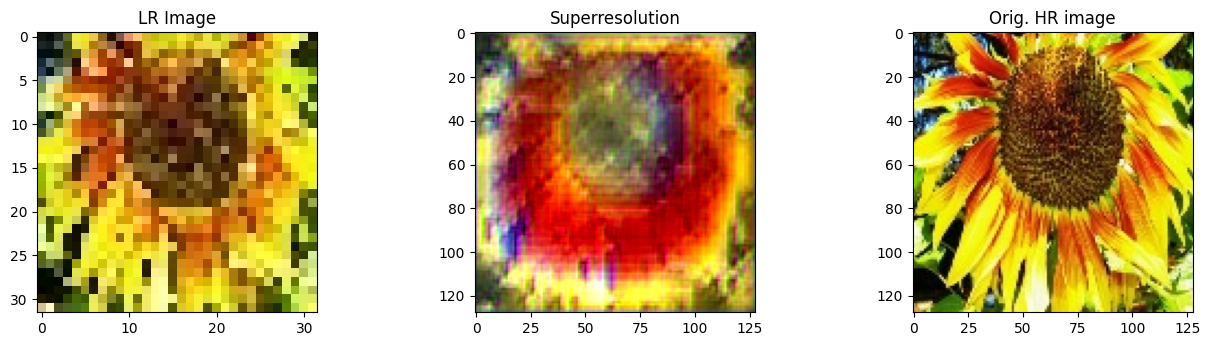

In [ ]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('/content/gdrive/MyDrive/DL_Project/gen_e.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

gen_image = generator.predict(src_image)



plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()



1/1 [==============================] - 0s 26ms/step


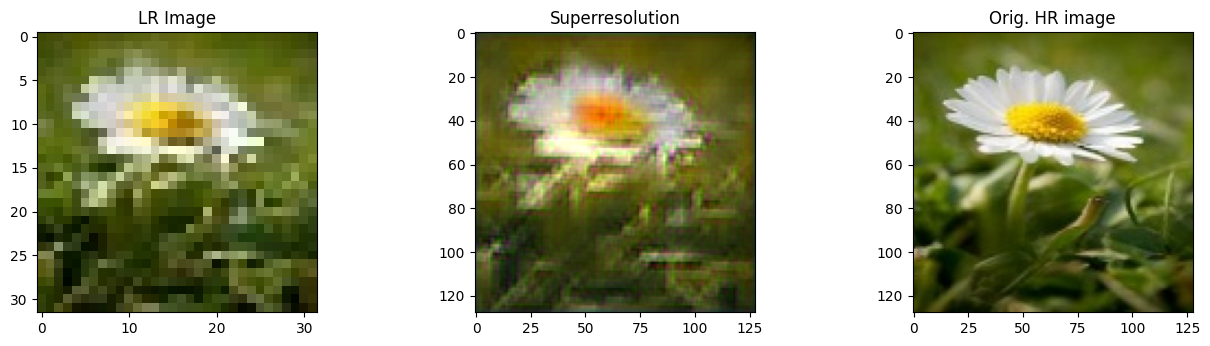

In [ ]:
sreeni_lr = cv2.imread("/content/gdrive/MyDrive/DL_Project/fl_dt/lr_images_1/daisy_1_-10790155265df092.jpg")
sreeni_hr = cv2.imread("/content/gdrive/MyDrive/DL_Project/fl_dt/hr_images_1/daisy_1_-10790155265df092.jpg")


sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
from PIL import Image
import random

data, info = tfds.load("tf_flowers", with_info=True)

target_dir = "/content/gdrive/MyDrive/DL_Project/fl_dt"

os.makedirs(target_dir, exist_ok=True)

dataset_list = list(data["train"].as_numpy_iterator())
random.shuffle(dataset_list)


images_extracted = 0

num_images_to_save = 600


for example in dataset_list:
    image = example["image"]
    label = example["label"]
    class_name = info.features["label"].int2str(label)


    image_filename = f"{class_name}_{label}_{hash(image.tobytes()):016x}.jpg"
    target_path = os.path.join(target_dir, image_filename)


    image_pil = Image.fromarray(image)
    image_pil.save(target_path)


    images_extracted += 1


    if images_extracted >= num_images_to_save:
        break

print(f"Saved {num_images_to_save} random images from the TF Flowers dataset to {target_dir}")


Saved 600 random images from the TF Flowers dataset to /content/gdrive/MyDrive/DL_Project/we
